### 48 - Logistic Regression Project
The goal is to create a classification model that can predict whether or not a person has presence of heart disease based on physical features of that person


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, PredictionErrorDisplay, classification_report, mean_absolute_error, mean_squared_error,  roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import GridSearchCV

### Prepare and Setup Data

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
target      303
dtype: int64

In [6]:
df['target'].unique()

array([1, 0], dtype=int64)

### Exploratory Data Analysis and Visualization

In [7]:
#let's describe and transpose the dataset to get a better visualization of the statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


<Axes: xlabel='target', ylabel='count'>

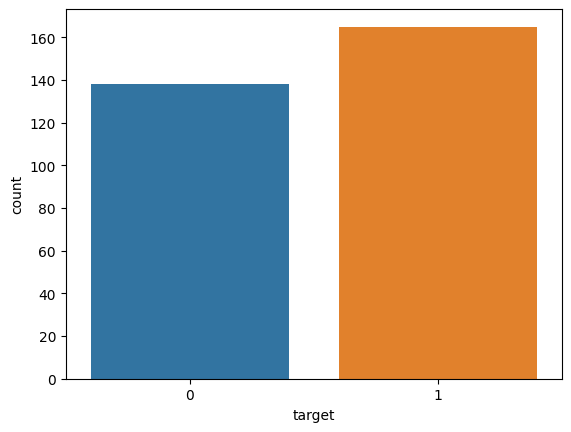

In [8]:
#create a barplot, using seaborn that shows the total counts per target value.
sns.countplot(x='target', data=df)

In [10]:
#create a pairplot that displays the relationships between the age, trest, chol, thalach, and target columns.
#check for columns first
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

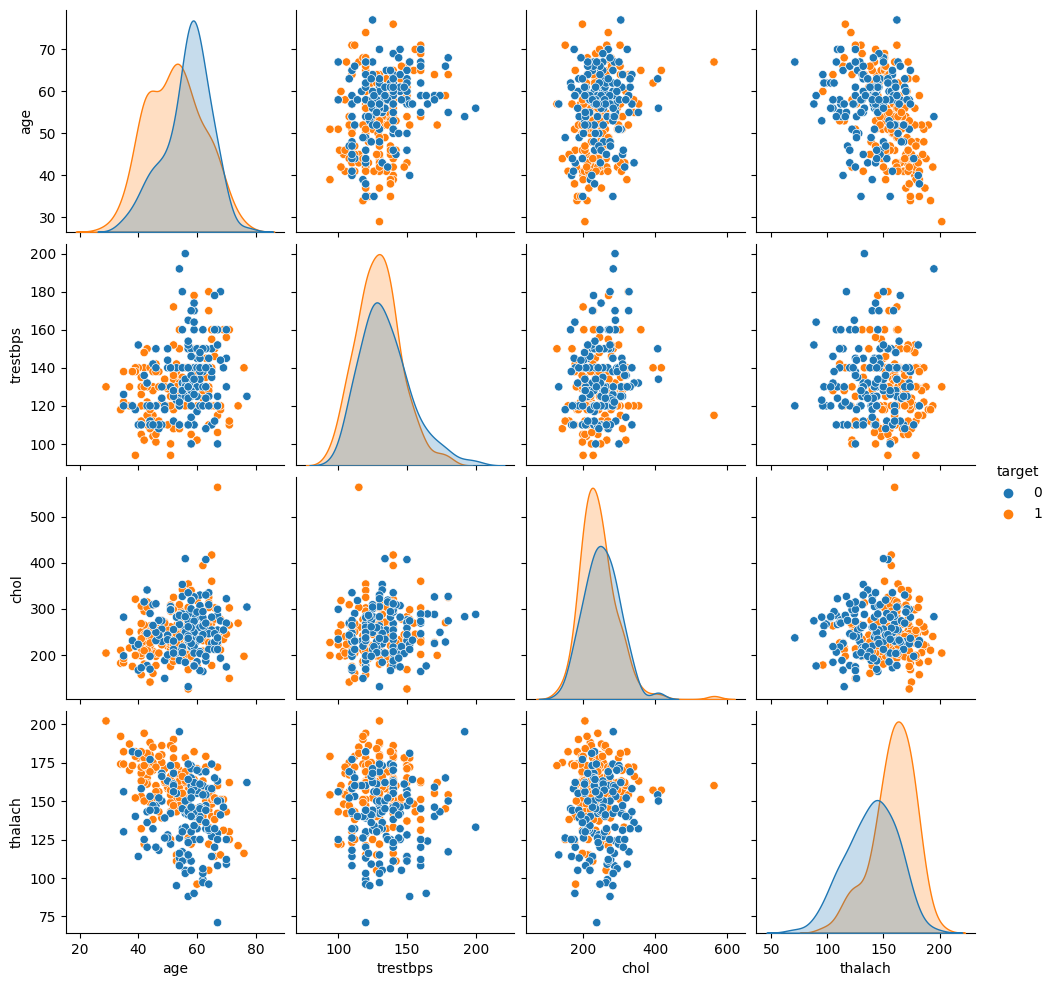

In [11]:
#run pairplot on specific columns
#hue will highlight the targets
sns.pairplot(df[[
    'age', 
    'trestbps', 
    'chol', 
    'thalach', 
    'target']],

hue='target')

<Axes: >

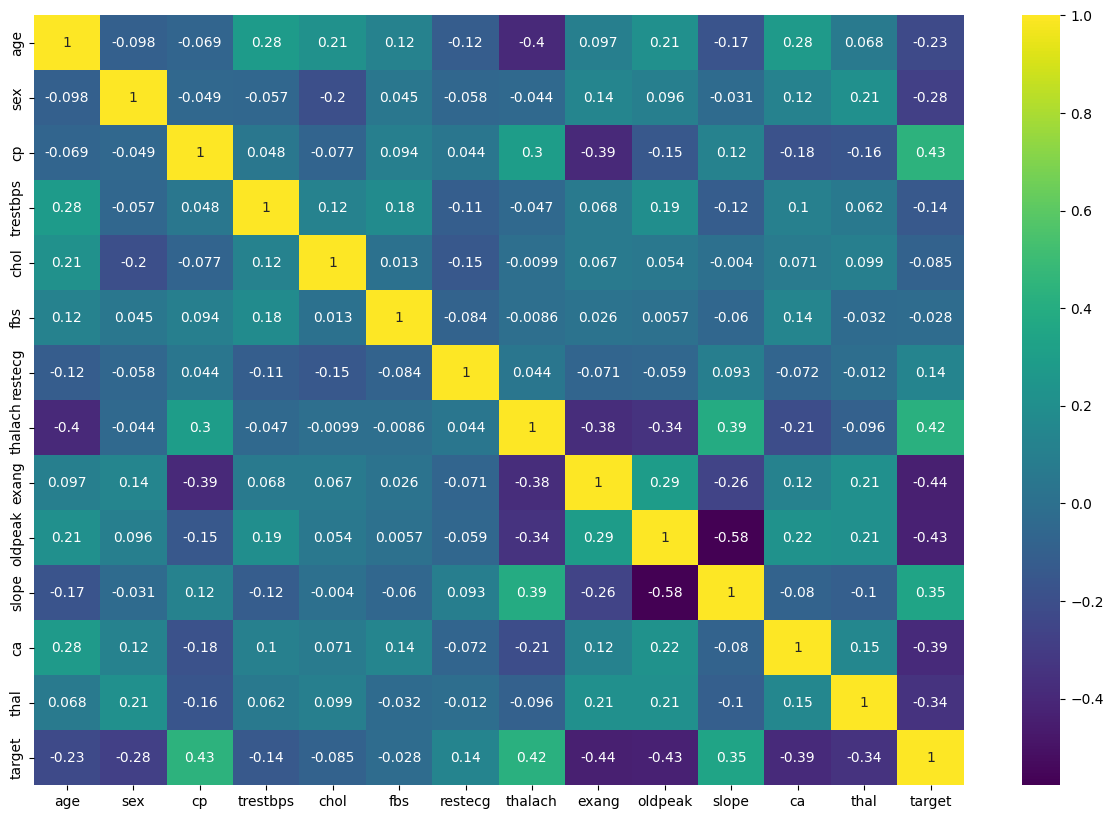

In [13]:
#create a heatmap that displays the correlation between all the columns
numeric_df = df.select_dtypes(include=['number'])

#calculate correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='viridis', annot=True)

### Machine Learning Process

In [14]:
#separate features from the labels into 2 objects, X and Y.
X = df.drop('target', axis=1)
y = df['target']

In [22]:
#perform train test split using sklearn.
#have around a 10% testing size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [23]:
#Create a standardscaler object and normalize the X train and test set feature data.
scaler = StandardScaler()

In [24]:
#have fit transform perform only on the X train data
scaled_X_train = scaler.fit_transform(X_train)

In [25]:
scaled_X_test = scaler.transform(X_test)

In [32]:
#create the logistic regression model and use cross-validation to find a well performing C value for hyper parameter search.

#we can use logisticregressionCV
log_model = LogisticRegressionCV()

In [33]:
#train and fit the logistic regression CV model
log_model.fit(scaled_X_train, y_train)

LogisticRegressionCV()

In [34]:
#report back and search optimal C value parameter
log_model.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [36]:
#perform predictions 
y_pred = log_model.predict(scaled_X_test)
y_pred

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [37]:
#find out accuracy score
accuracy_score(y_test, y_pred)

0.8387096774193549

### Model Performance Evalution

In [39]:
#create a confusion matrix array
confusion_matrix(y_test, y_pred)

array([[12,  3],
       [ 2, 14]], dtype=int64)

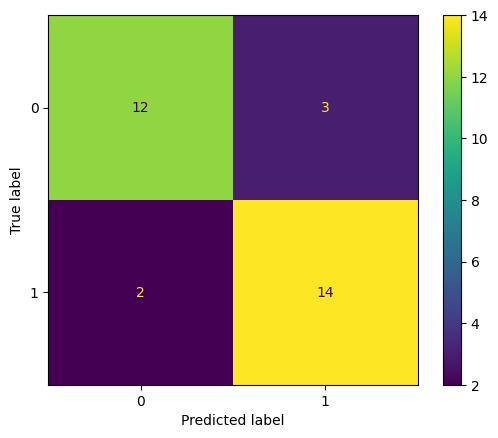

In [40]:
#Create a confusion matrix plot
ConfusionMatrixDisplay.from_estimator(log_model, scaled_X_test, y_test)

In [45]:
#create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.82      0.88      0.85        16

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31



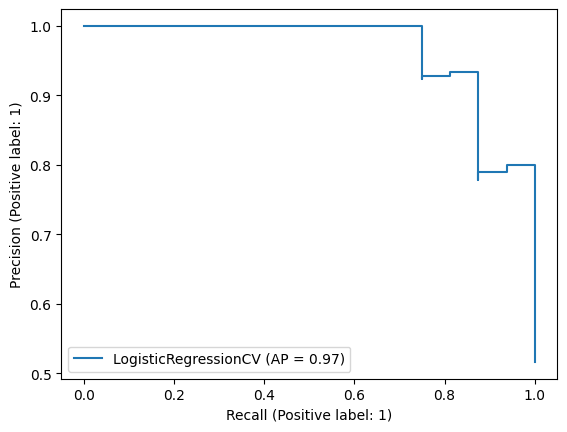

In [46]:
#plot predicion recall plot display
PrecisionRecallDisplay.from_estimator(log_model, scaled_X_test, y_test)

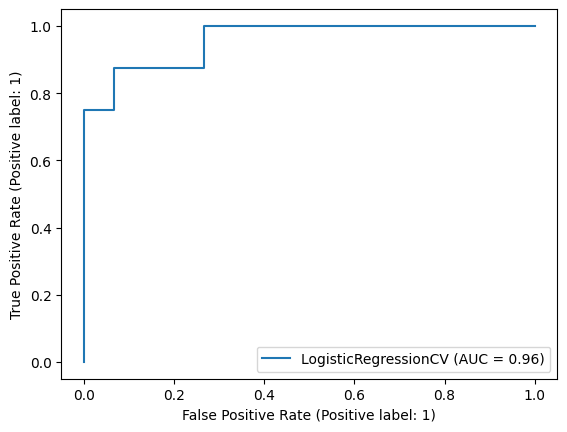

In [47]:
#plot ROC curve
RocCurveDisplay.from_estimator(log_model, scaled_X_test, y_test)

### Final Prediction and Task

A patient with the following features has come into the medical office:
- age = 48.0
- sex = 0.0
- cp = 2.0
- trestbps = 130.0
- chol = 275.0
- fbs = 0.0
- restecg = 1.0
- thalach = 139.0
- exang = 0.0
- oldpeak = 0.2
- slope = 2.0
- ca = 0.0
- thal = 2.0


Predict the patient's condition based on these features

In [48]:
#create an array for the patient's features
patient = [[ 54. ,   1. ,   0. , 122. , 286. ,   0. ,   0. , 116. ,   1. ,
          3.2,   1. ,   2. ,   2. ]]

In [49]:
X_test.iloc[-1]

age          54.0
sex           1.0
cp            0.0
trestbps    122.0
chol        286.0
fbs           0.0
restecg       0.0
thalach     116.0
exang         1.0
oldpeak       3.2
slope         1.0
ca            2.0
thal          2.0
Name: 268, dtype: float64

In [50]:
y_test.iloc[-1]

0

In [51]:
#predict using the log model
log_model.predict(patient)

array([0], dtype=int64)

In [52]:
log_model.predict_proba(patient)

array([[9.99999862e-01, 1.38455917e-07]])